![liqomics_logo](images/liqomics_logo.png)

### **About LIQOMICS**

- **Academic Spin-off from Cologne:**  
  Focused on cutting-edge tumor diagnostics through liquid biopsy technology.

---

### **Key Service: LymphoVista**
- **What It Does:**  
  Detects and monitors **lymphomas** and **hematological cancers**.
  
- **How It Works:**  
  - **Blood Sample Analysis:** Detects **cell-free DNA** and **circulating tumor DNA**.  
  - **Disease Monitoring:** Tracks **Minimal Residual Disease (MRD)** to assess treatment response.


### **Sensitive MRD Testing for Cancer Monitoring**

<img src="images/mrd.jpg" alt="Figure" width="800" height="600">

## **Cell-Free DNA (cfDNA)**

### **What Is cfDNA?**
- **Degraded Small DNA Fragments:**  
  - Size: **50 - 200 bp**, cleaved by **nucleases**.

---

### **Source of cfDNA:**
- **Released by Dead Cells:**  
  - Occurs via **apoptosis**, **necrosis**, or **active secretion** from living cells.

---

### **Key Molecular Features:**
- **Tissue-Specific Signatures:**  
  - **Fragment Size:** Reflects tissue-specific fragmentation patterns.  
  - **Methylation Status:** Epigenetic modifications characteristic of cell types.  
  - **End Motifs:** Specific DNA ends reflecting nuclease activity.



### **Chromatin Organization and Nuclease Activity Define cfDNA Signatures**

<img src="images/cell_free_dna.png" alt="Figure" width="800">

## **Projects Overview**

---

### **1. Hodgkin Lymphoma Project**
- **Data Source:**  
  - Cell-free DNA sequencing from **Hodgkin Lymphoma Patients**.
  - Samples collected **before** and **after two cycles of chemotherapy**.
  - Additional **relapse information** included.

- **Goal:**  
  - Build a **Machine Learning Model** to **predict relapse** after treatment.

- **Result:**  
  - **Challenge:** Insufficient sample size for a reliable predictive model.

---


## **Projects Overview**

---

### **2. Solid Tumors (Finale_DB Project)**
- **Data Source:**  
  - Cell-free DNA sequencing from **4 Publications:**  
    - **Jiang_2015, Cristiano_2019, Snyder_2016, Sun_2019**.  
  - **>800 Samples:** Includes both **healthy** and **cancer** samples.

- **Goal:**  
  - Develop a **Machine Learning Model** to **distinguish cancer from non-cancer** for solid tumors.

---

**Note:** Detailed results from this project will be presented on the following slides.

In [5]:
from scripts.downsampling_scjs import downsampling_nas
from scripts.visualize_features import create_dfs_for_plotting, calc_chromosome_coverage
from scripts.visualize_normalized_data import ggboxplot_scjs, interactive_plot, import_df_usecols
from scripts.feature_selection_scjs import (high_correlation_mw_filter, selection_tpot_split, del_bin_and_other_features,
                                            selection_tpot_split_stratified, feature_selection, generate_export_tpot_set)
from scripts.features_results_analysis import (extract_acc_and_feat_Importance, filter_max_weighted_classifiers, print_features_count,
                                                            finding_duplicates, top_ten_importance_features, filter_importance_features_tpot)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from IPython.display import display, HTML, display_html
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [ ]:
# Define the header text
header_text = "Summary of Data Sources and Samples"

# Example DataFrame (replace with your actual data)
samples = pd.read_csv('results/downsampling_scjs_241128_smp_output.csv', usecols=['disease', 'source', 'sample'])

# Group and summarize
full_summary = samples.groupby('source').agg({
    'disease': lambda x: '<br>'.join(sorted(x.unique())),
    'sample': pd.Series.nunique
}).reset_index()

# Rename columns for clarity
full_summary.columns = ['Source', 'Diseases Covered', 'Total Samples']

# Split DataFrame into two halves
chunk_size = len(full_summary) // 2
chunks = [full_summary.iloc[:chunk_size], full_summary.iloc[chunk_size:]]

# Generate HTML with Improved CSS
html_tables = "".join(
    f"""
    <div style="display: inline-block; vertical-align: top; width: 48%; margin: 0; padding: 5px;">
        {chunk.style.set_table_attributes(
            'style="width: 100%; table-layout: fixed; border: 1px solid black; font-size: 13px;"'
        ).hide(axis="index").to_html()}
    </div>
    """
    for chunk in chunks
)

# Create Final HTML with Header
html_output = f"""
<div style="text-align: center; margin-bottom: 15px;">
    <h2 style="margin: 0; padding: 0; font-size: 22px;">{header_text}</h2>
</div>

<div style="display: flex; justify-content: space-between; align-items: flex-start; width: 100%;">
    {html_tables}
</div>
"""

# Display the tables side by side
display_html(html_output, raw=True)

Source,Diseases Covered,Total Samples
Cristiano_2019,Bile_duct_cancerBreast_cancerColorectal_cancerDuodenal_cancerGastric_cancerHealthyLung_cancerOvarian_cancerPancreatic_cancer,536
Jiang_2015,CirrhosisHealthyHepatitis_BLiver_cancer,225
Source,Diseases Covered,Total Samples
Snyder_2016,Bladder_cancerBreast_cancerColorectal_cancerEsophageal_cancerHead_and_neck_cancerHealthyInflammatory_bowel_diseaseKidney_cancerLiver_cancerLung_cancerOvarian_cancerPancreatic_cancerProstate_cancerSkin_cancerSystemic_lupus_erythematosusTesticular_cancerUterine_cancer,58
Sun_2019,Colorectal_cancerLiver_transplant,29


## **Pipeline**

<div style="display: flex; align-items: center; justify-content: space-between;">

<!-- Left Side Text -->
<div style="width: 35%;">

1. Downsampling

2. Feature Normalization

3. Feature Selection  

4. Machine learning (TPOT)  

</div>

<!-- Right Side Image -->
<div style="width: 70%; text-align: right;">
<img src="images/splits.png" alt="Figure" style="width: 100%; height: auto;">
</div>

</div>

# Finale DB Data - Final Pipeline

## **Downsampling Process**

### **Key Steps:**
1. **Handling Coverage Variability:**  
   - Coverage between samples **varies significantly**, affecting comparability.

2. **Equalization:**  
   - **Downsample all samples** to the same number of **DNA fragments** to ensure consistency in analysis.


In [29]:
downsampling = False

if downsampling:
    source_list = ['Outputs/Jiang_2015', 'Cristiano_2019', 'Snyder_2016', 'Sun_2019']
    output_downsampling_smp = '/mnt/nas/research/FinaleDB_hg38/blood_plasma/output_downsampling_241128_smp/'
    nas_dir = '/mnt/nas/research/FinaleDB_hg38/blood_plasma/'

    downsampling_nas(source_list, 'smp', nas_dir, output_downsampling_smp, export_files=True)

# Alternativly run script 'downsampling_SCJS_241127.py'

Number of total samples after downsampling: 848


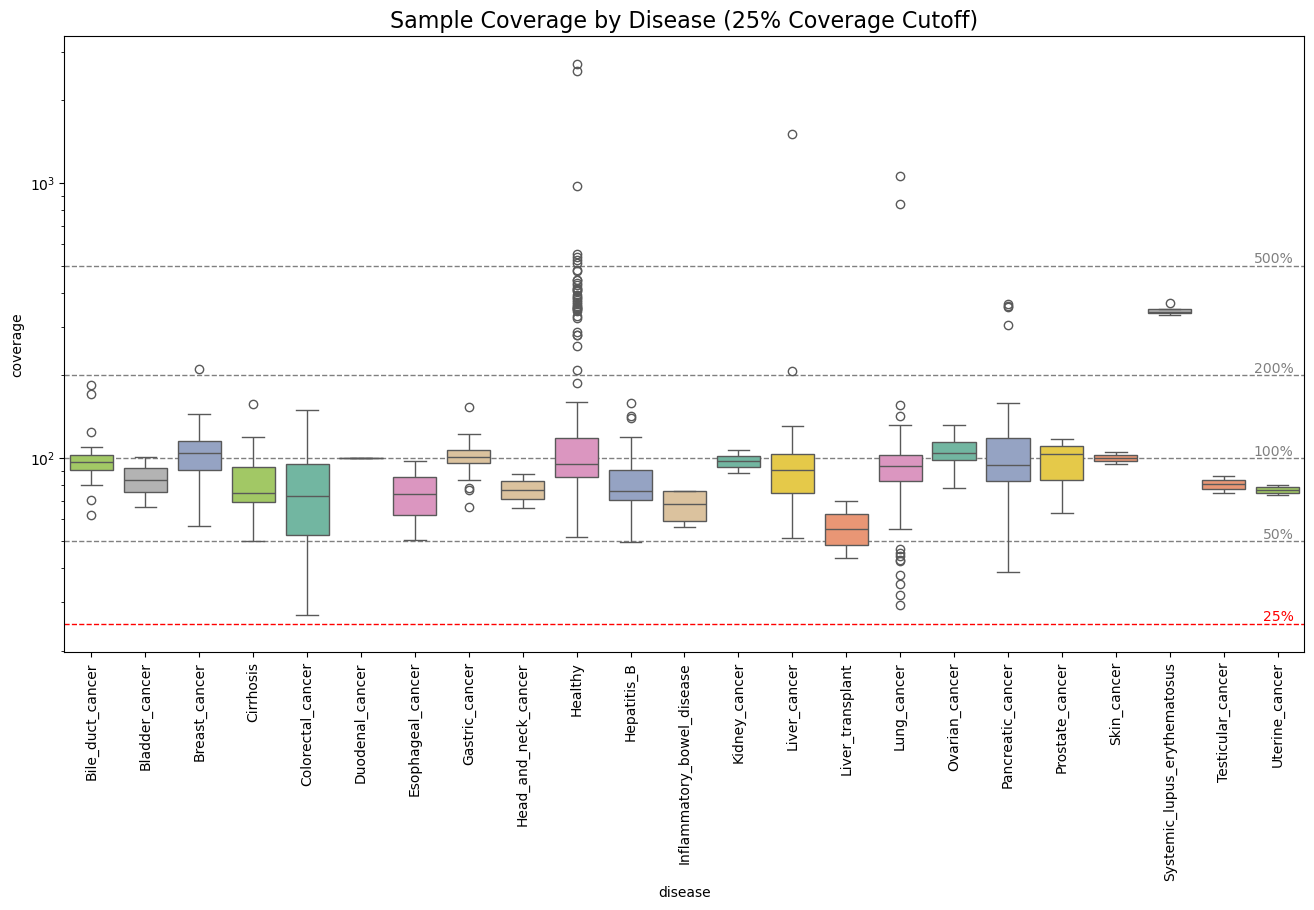

In [88]:
csv_ds = 'results/downsampling_scjs_241128_smp_output.csv'
csv_cov = 'results/downsampling_scjs_241128_smp_outputCov.csv'
df_plot, df_cov_plot, sorted_order = create_dfs_for_plotting(csv_ds, csv_cov)

plt.figure(figsize=(16,8))
dotted_lines = [500, 200, 100, 50, 25]
for i in dotted_lines:
    color = 'red' if i == 25 else 'gray'
    plt.axhline(y=i, color=color, linestyle='--', linewidth=1)
    plt.text(x=22.3, y=i, s=f'{i}%', color=color, va='bottom', ha='right')
sns.boxplot(data=df_cov_plot, x='disease', y='coverage', hue='disease', palette='Set2', order=sorted_order)
plt.title('Sample Coverage by Disease (25% Coverage Cutoff)', fontsize=16)
plt.xticks(rotation=90)
plt.yscale('log')
plt.show()

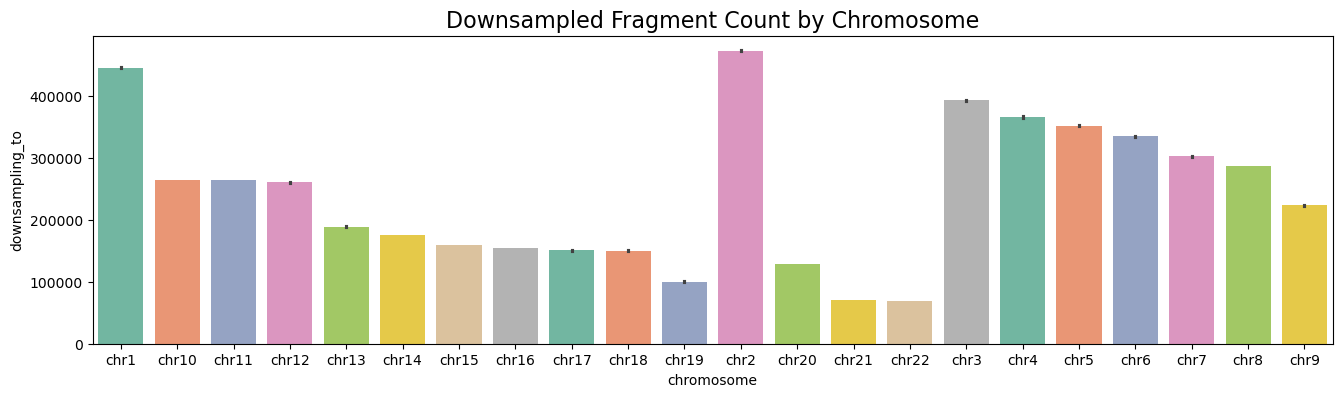

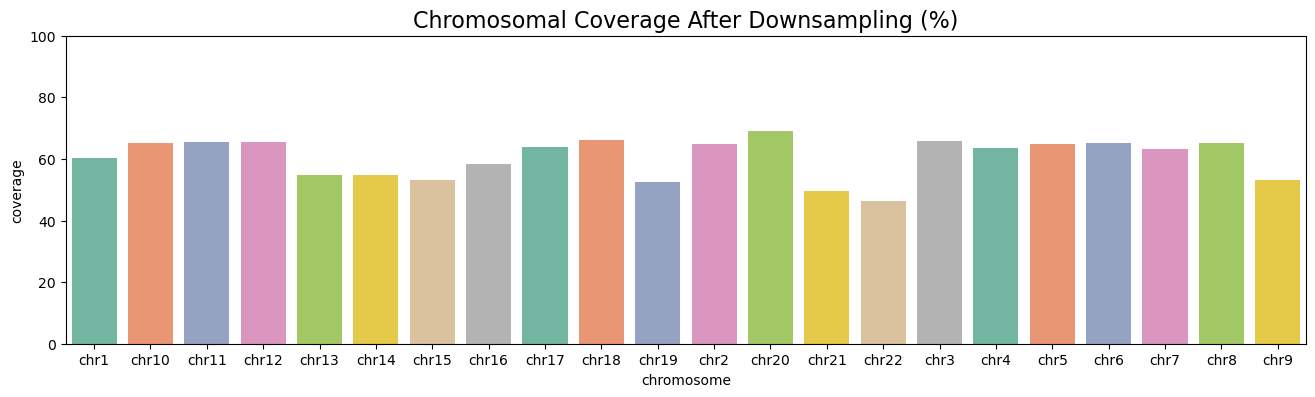

In [89]:
plt.figure(figsize=(16,4))
sns.barplot(data=df_plot.loc[df_plot['strand'] == 'reverse'], x='chromosome', y='downsampling_to', hue='chromosome', palette='Set2')
plt.title('Downsampled Fragment Count by Chromosome', fontsize=16)
plt.show()

csv_chr_lengths = 'data/chromosome_length_diploid_genome.txt'
frag_chr_rev = calc_chromosome_coverage(df_plot, csv_chr_lengths, 'reverse')

plt.figure(figsize=(16,4))
sns.barplot(data=frag_chr_rev, x='chromosome', y='coverage', hue='chromosome', palette='Set2')
plt.ylim(0,100)
plt.title('Chromosomal Coverage After Downsampling (%)', fontsize=16)
plt.show()

## **Feature Normalization Process**

### **Key Steps:**
1. **Window Sampling:**
    - Process **5 million windows** on each chromosome for accurate feature representation.

2. **Normalization:**
    - Apply **feature normalization** to prepare data for **machine learning** models.

3. **Data Readiness:**
    - Ensure features are **scaled** and **standardized** for better model performance.


In [5]:
strands = ['fwd', 'rev']

for strand in strands:
    df = pd.read_csv(f'results/norm_data_scjs_241128_smp_output_5M_{strand}.csv', index_col=0, nrows=5)
    df2 = pd.read_csv(f'results/norm_data_scjs_241128_smp_output2_5M_{strand}.csv', index_col=0, nrows=5)
    print(f'### {strand} ###')
    n_cols1 = df.shape[1]-3 # subtract 'source', 'disease', 'strand'
    n_cols2 = df2.shape[1]-4 # subtract 'source', 'disease', 'target', 'strand'
    print(f'Number of features  after normalization: {n_cols1}') 
    print(f'Number of features after filtering out columns containing empty or inf values: {n_cols2}')
    print(f'Removed features by filtering: {n_cols1 - n_cols2}')
    print()
    del df, df2

### fwd ###
Number of features  after normalization: 78090
Number of features after filtering out columns containing empty or inf values: 76670
Removed features by filtering: 1420

### rev ###
Number of features  after normalization: 78090
Number of features after filtering out columns containing empty or inf values: 76801
Removed features by filtering: 1289



In [6]:
norm_data = 'results/norm_data_scjs_241128_smp_output2_5M_rev.csv'
def import_df_usecols(feature, file_path=norm_data):
    df_cols = pd.read_csv(file_path, index_col=0, nrows=2)
    cols = [col for col in df_cols if col.endswith(feature)] + ['sample', 'source', 'disease', 'target', 'strand']
    df = pd.read_csv(file_path, index_col=0, usecols=cols)
    return df
df = import_df_usecols('med')
df

,source,disease,target,strand,chr1-P0m-med,chr1-P100m-med,chr1-P105m-med,chr1-P10m-med,chr1-P110m-med,chr1-P115m-med,...,chr9-P40m-med,chr9-P5m-med,chr9-P60m-med,chr9-P65m-med,chr9-P70m-med,chr9-P75m-med,chr9-P80m-med,chr9-P85m-med,chr9-P90m-med,chr9-P95m-med
sample,,,,,,,,,,,,,,,,,,,,,
EE85723,Sun_2019,Colorectal_cancer,1,reverse,142.0,150.0,148.5,144.5,145.0,146.0,...,127.0,147.0,148.0,146.5,149.5,146.0,147.0,145.0,145.5,146.0
EE85724,Sun_2019,Colorectal_cancer,1,reverse,144.0,151.5,151.5,145.5,148.0,148.5,...,133.5,149.5,151.5,146.0,150.0,149.0,149.0,147.0,148.0,148.0
EE85725,Sun_2019,Liver_transplant,0,reverse,169.5,170.5,169.0,169.0,170.5,169.5,...,169.0,169.5,169.0,170.5,170.0,169.0,170.0,169.0,169.5,169.5
EE85726,Sun_2019,Colorectal_cancer,1,reverse,145.5,153.5,152.5,146.0,148.5,150.5,...,133.0,150.5,150.5,149.0,152.5,149.5,150.5,149.0,149.0,148.0
EE85727,Sun_2019,Colorectal_cancer,1,reverse,142.0,151.5,150.5,144.0,147.0,147.0,...,128.5,149.0,150.0,148.5,150.5,148.5,148.5,147.0,148.0,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EE88321,Cristiano_2019,Pancreatic_cancer,1,reverse,168.0,167.5,167.5,167.5,167.5,167.5,...,168.0,167.5,168.0,167.5,167.5,168.0,167.0,167.5,167.0,167.0
EE88322,Cristiano_2019,Pancreatic_cancer,1,reverse,164.5,163.5,163.0,163.5,163.5,163.5,...,163.0,163.5,164.5,163.5,163.0,163.0,163.5,163.0,163.0,163.5
EE88323,Cristiano_2019,Pancreatic_cancer,1,reverse,164.0,164.5,164.5,164.0,164.5,164.0,...,164.5,164.0,164.0,164.0,164.0,164.5,164.5,164.0,163.5,164.5


### Feature Visualization

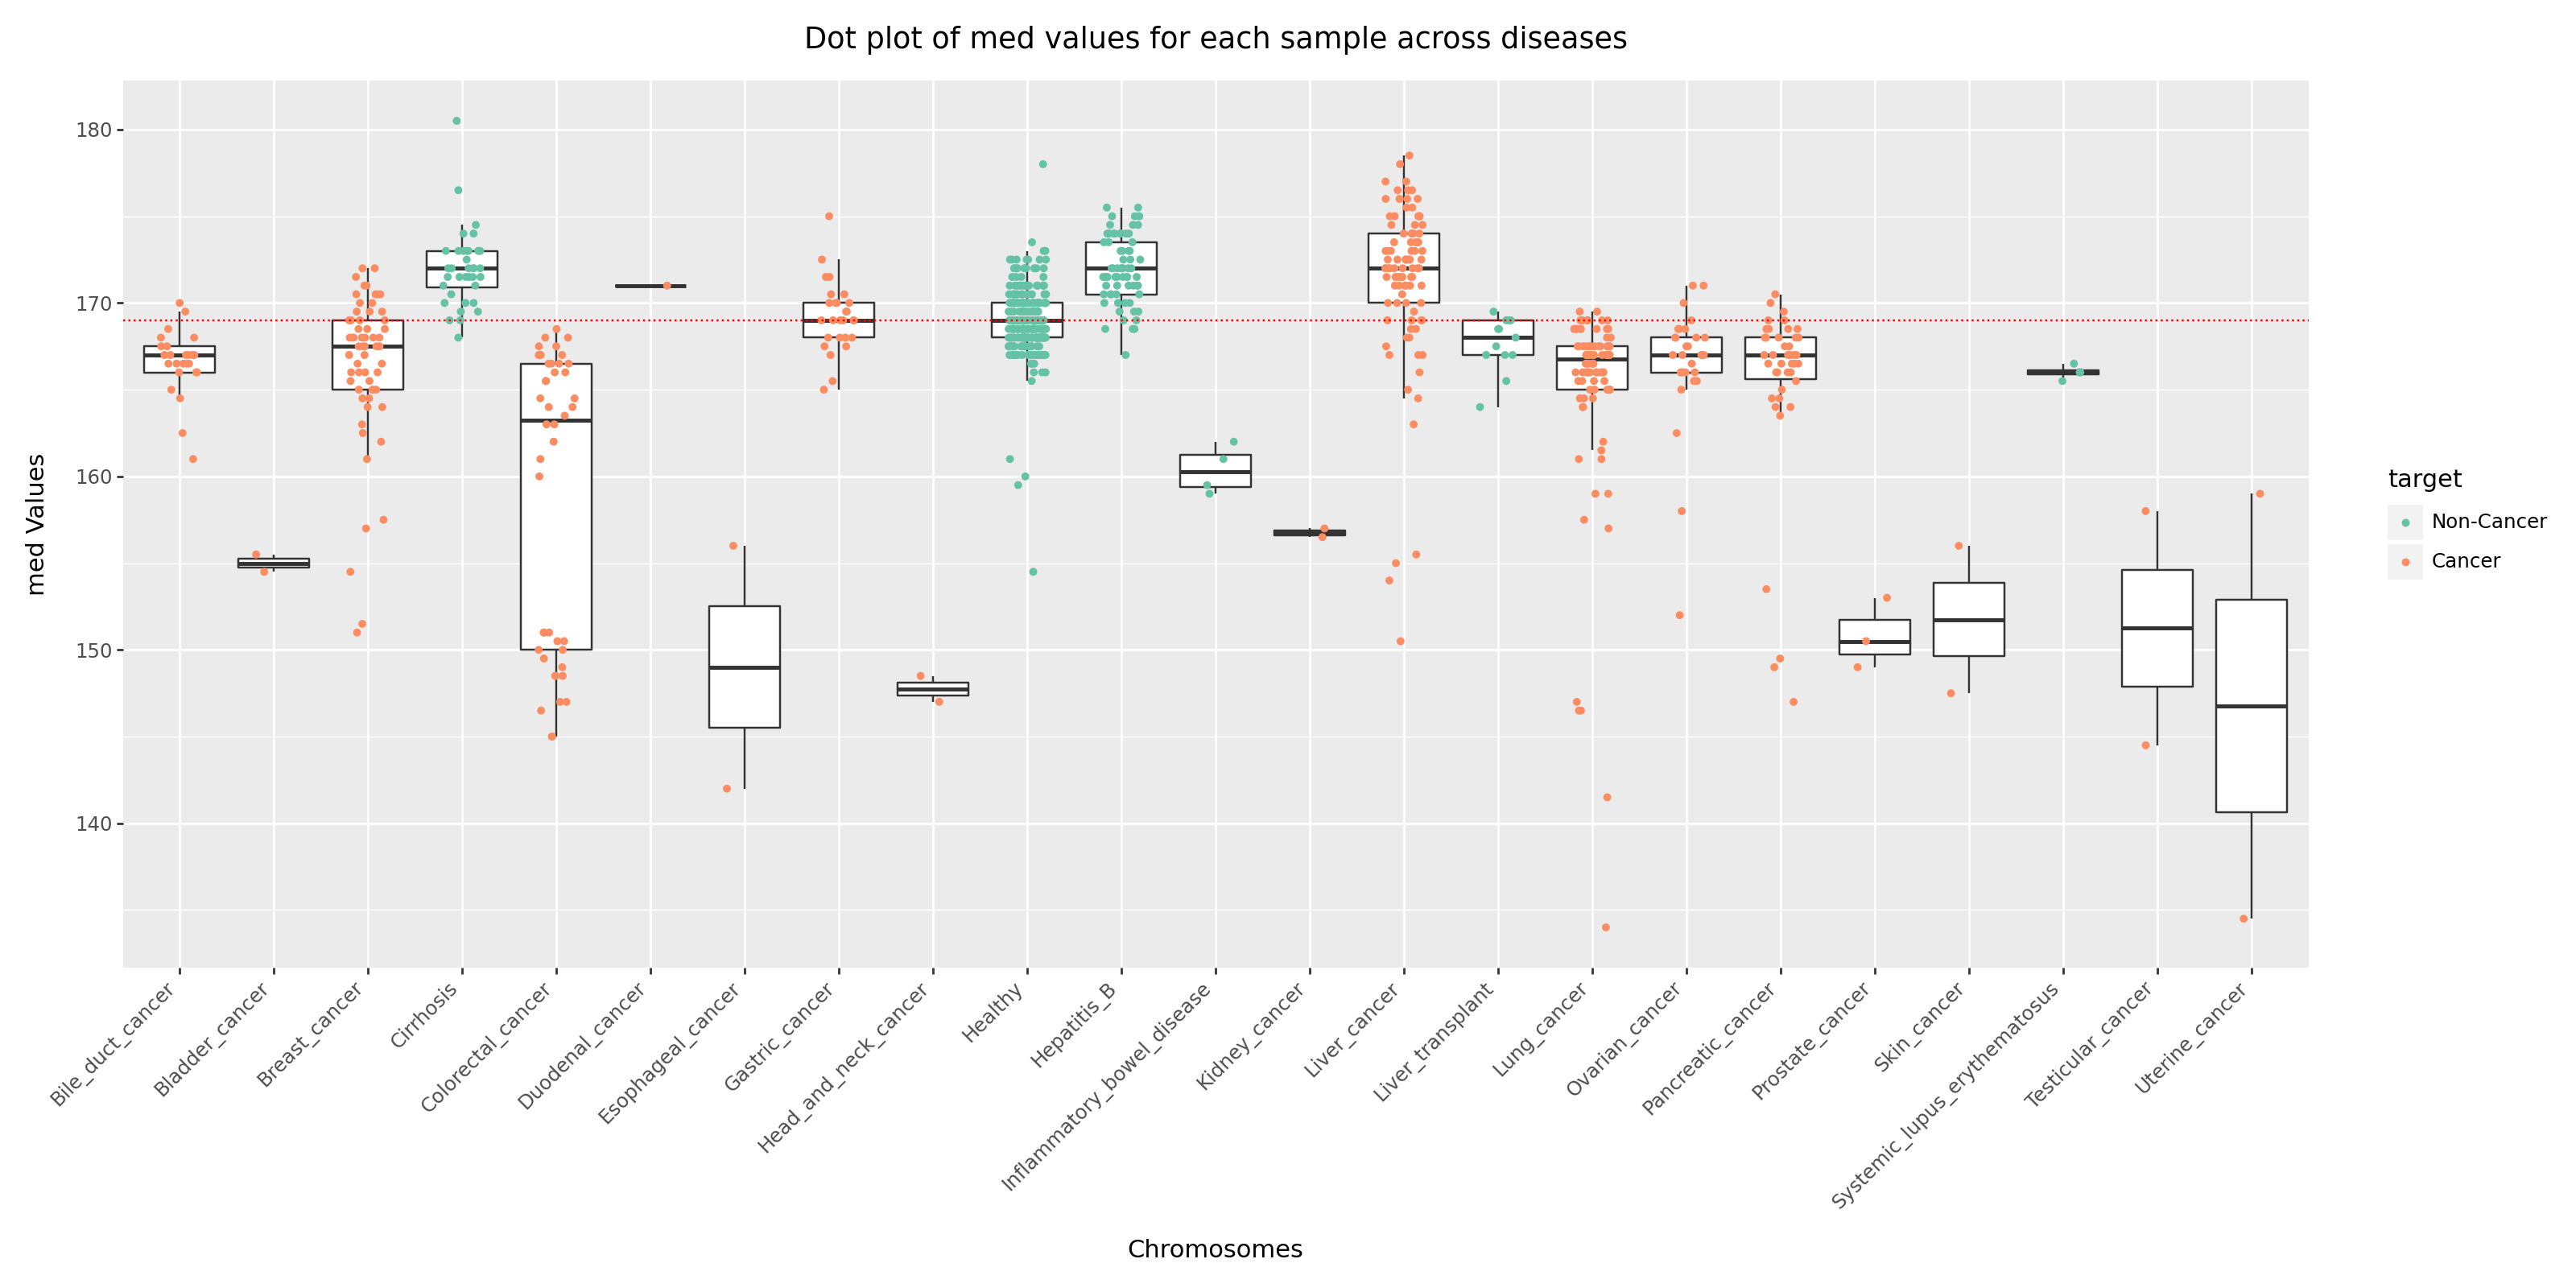

In [37]:
norm_data = 'results/norm_data_scjs_241128_smp_output2_5M_rev.csv'

med_quart_list = ['med', 'TG_166_250_bimers_starts', 'AT_166_250_bimers_ends']

df = import_df_usecols('med', norm_data)
ggboxplot_scjs(df, 'med', 'sample', 'reverse')

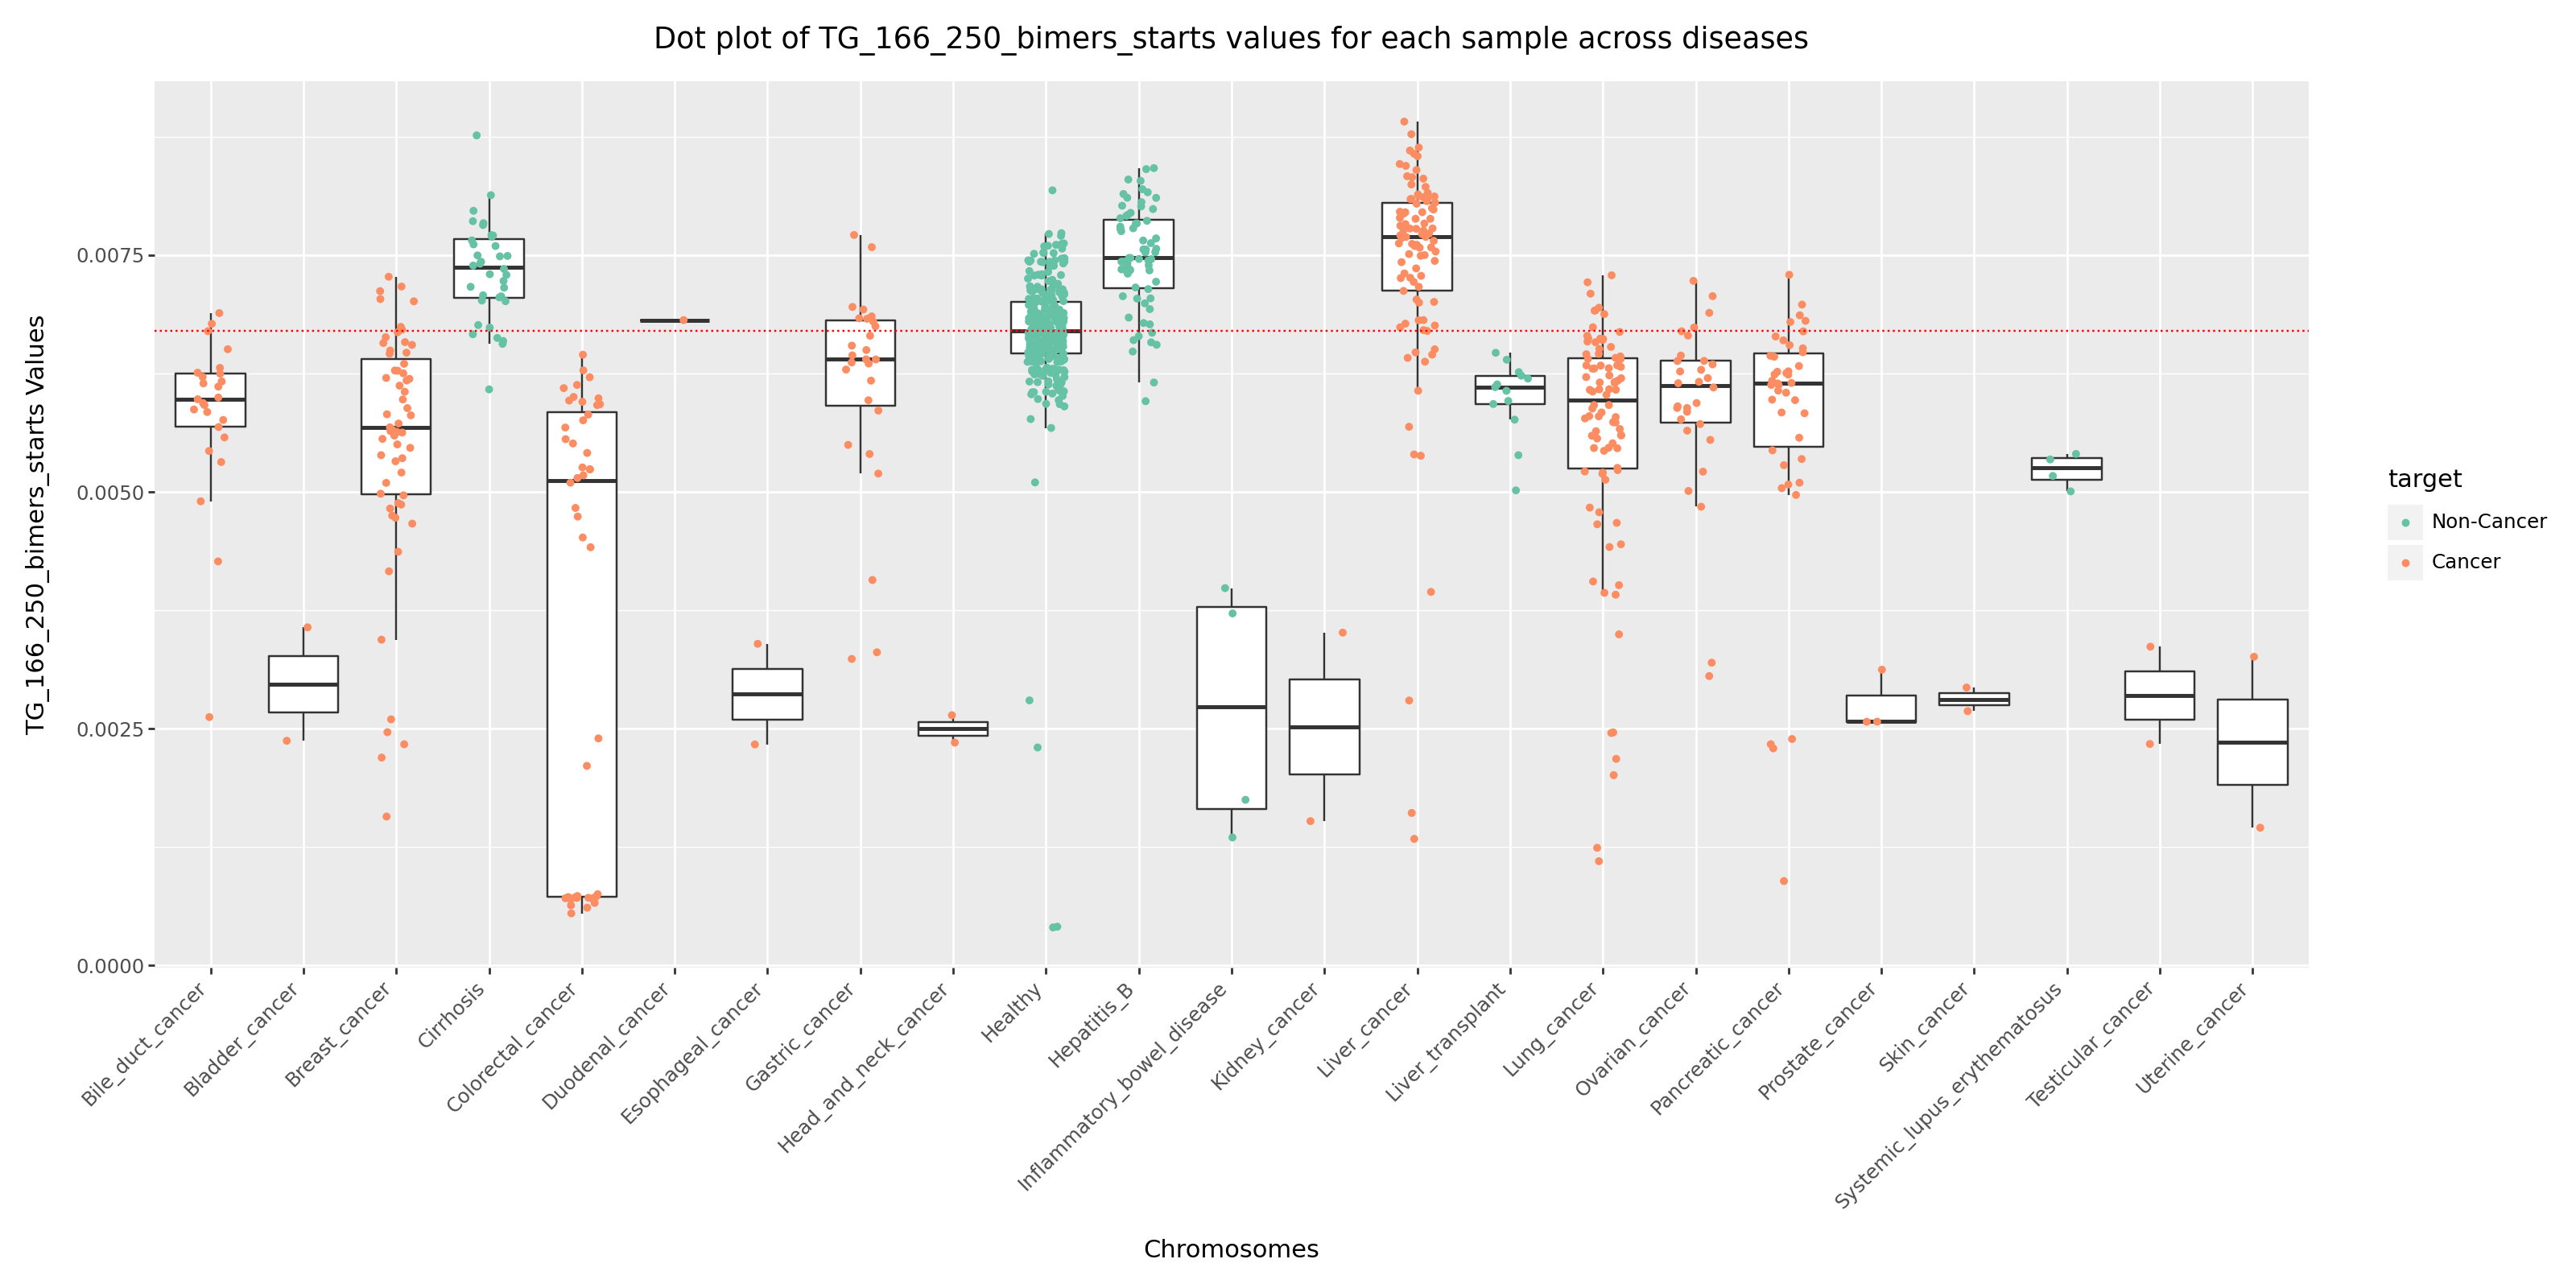

In [38]:
df = import_df_usecols('TG_166_250_bimers_starts', norm_data)
ggboxplot_scjs(df, 'TG_166_250_bimers_starts', 'sample', 'reverse')

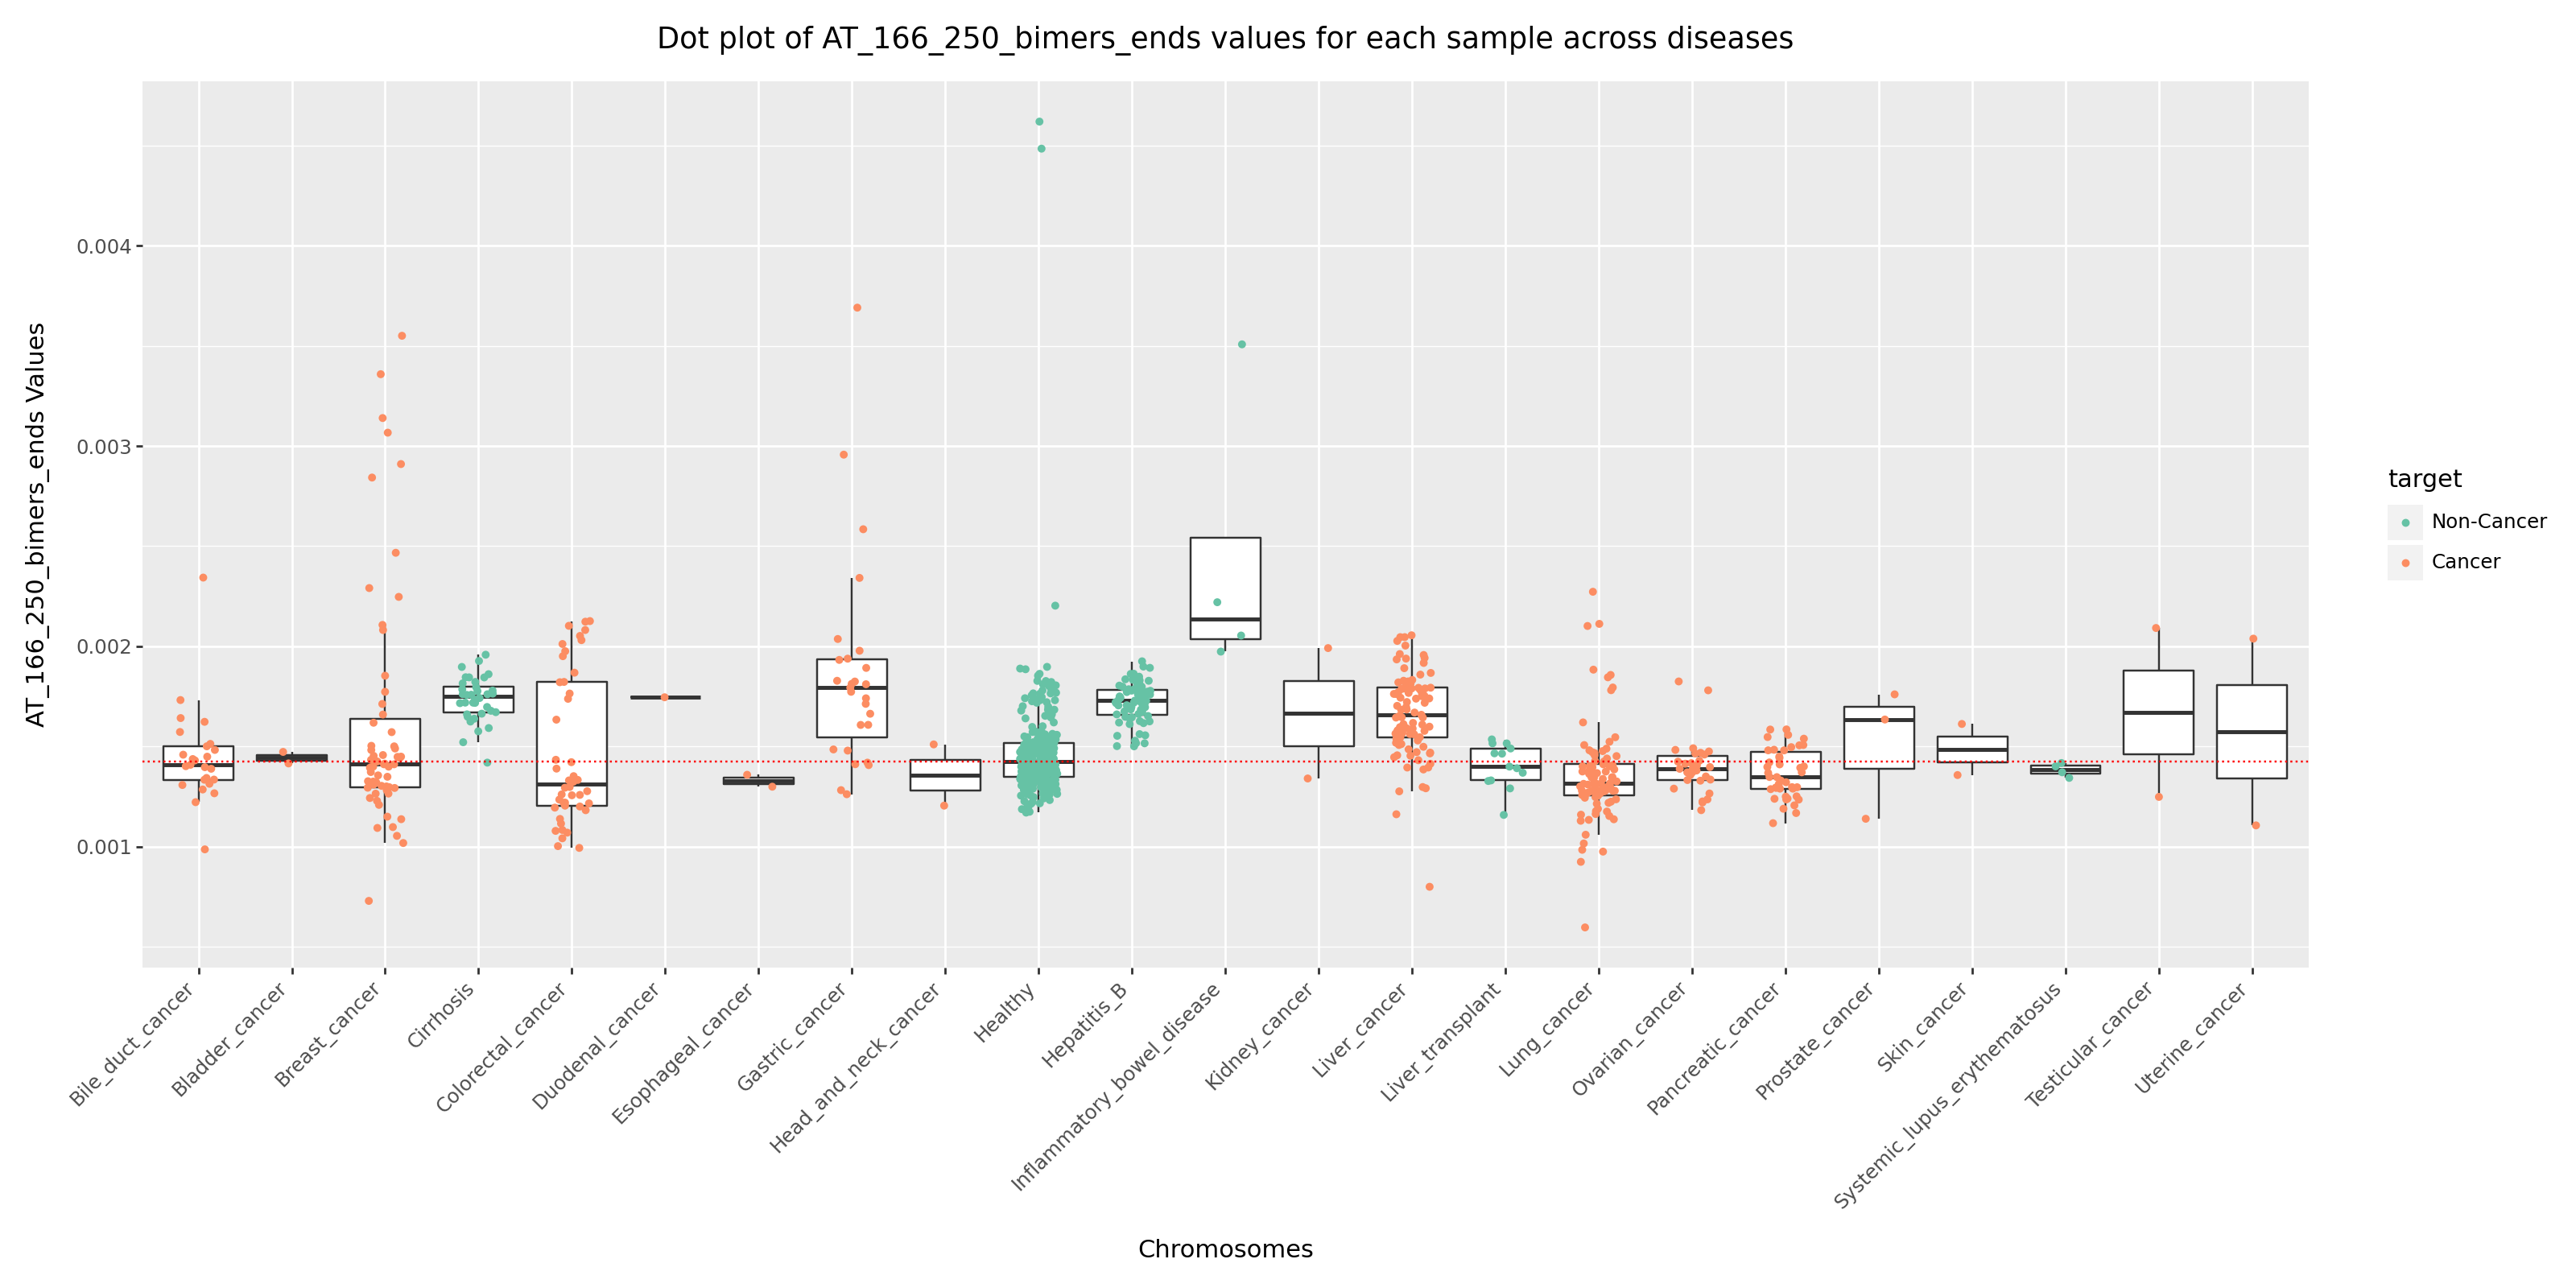

In [39]:
df = import_df_usecols('AT_166_250_bimers_ends', norm_data)
ggboxplot_scjs(df, 'AT_166_250_bimers_ends', 'sample', 'reverse')

## **Feature Selection Process**

### **Key Steps:**
1. **Sample Selection:**  
   - Use **5%** of samples (42 out of 828) for feature selection to avoid overfitting.

2. **Significance Testing:**  
   - Apply the **Mann-Whitney U Test** to remove **non-significant features** (p > 0.05).

3. **Correlation Handling:**  
   - **Group correlated features** (threshold: |r| > 0.8) and retain the **most significant feature** from each group.

---

### **Result:**  
- **Selected Features:** **78 Features** out of **76,801 Features** (0.1% selected)



In [56]:
df_5m = pd.read_csv('results/norm_data_scjs_241128_smp_output2_5M_rev.csv', index_col = 0)
df_5m = del_bin_and_other_features(df_5m, ['mode', 'sum', 'std'])

In [60]:
feat_select_5m2_plus, tpot_5m2_plus = selection_tpot_split_stratified(df_5m)

# selected_features_5m2_plus = feature_selection(feat_select_5m2_plus, 0.7, 0.01)
# selected_features_5m2_plus.to_csv('results/norm_data_scjs_241128_smp_selected_features2plus_rev.csv')

selected_features_5m2_plus = pd.read_csv('results/norm_data_scjs_241128_smp_selected_features2plus_rev.csv', index_col=0)

#generate_export_tpot_set(selected_features_5m2_plus, tpot_5m2_plus, 'input_tpot_scjs_241128_smp_5m2_plus')

selected_features_5m2_plus.head(2)

Feature Selection Samples: 42
Remaining Samples for Model Training: 806


,chr1-P140m-AC_166_250_bimers_ends,chr1-P145m-CA_166_250_bimers_ends,chr1-P155m-TA_166_250_bimers_ends,chr1-P215m-GG_80_165_bimers_starts,chr1-P70m-GT_bimers_starts,chr1-P90m-bimers_end_80_165_mds,chr10-P20m-CG_166_250_bimers_ends,chr11-P130m-AT_166_250_bimers_starts,chr11-P25m-CGN_NCG_ratios,chr11-P35m-bimers_start_80_165_mds,...,chr7-P65m-AC_166_250_bimers_ends,chr7-P65m-GT_166_250_bimers_starts,chr8-P115m-CG_166_250_bimers_starts,chr8-P125m-bimers_end_80_165_mds,chr8-P40m-AG_bimers_ends,chr9-P100m-AA_166_250_bimers_ends,chr9-P125m-CT_bimers_starts,chr9-P30m-CGN_NCG_ratios,chr9-P60m-CG_bimers_ends,chr9-P65m-AG_166_250_bimers_starts
sample,,,,,,,,,,,,,,,,,,,,,
EE87914,0.004662,0.002667,0.002361,0.002032,0.061149,0.732766,0.000490,0.002611,1.368421,0.727566,...,0.003424,0.003203,0.000374,0.734192,0.077093,0.002699,0.076003,1.838710,0.008621,0.001907
EE85729,0.000000,0.005612,0.004261,0.001777,0.025653,0.720809,0.001251,0.001136,1.075000,0.721542,...,0.001052,0.001052,0.000383,0.714684,0.070532,0.001659,0.070795,1.059701,0.018830,0.003297


## **TPOT**

<img src="images/splits.png" alt="Figure" style="width: 80%; height: auto;">

### **Classifier Performance on Training Data**

#### **Best Classifiers After Training**

In [73]:
df_class = pd.read_csv('results/1-input_tpot_scjs_241128_smp_5m2_plus/classifiers/input_tpot_scjs_241128_smp_5m2_plus-classifiers_results_mean.csv', index_col=0)

df = df_class.reset_index()
idx = df.groupby('Classifier')['Weighted_Score'].idxmax()

filtered_df = (
    df[df.index.isin(idx)]
    .drop(columns=['Unnamed: 0', 'Hyperparameter_Count.1', 'Fold_ID'])
    .rename(columns={'Hyperparameter_Count': 'HP_count'})
    .style
    .hide(axis='index')
    #.set_caption("Best Classifiers after Training")
    # .set_properties(**{
    #     'font-size': '12px',       # Reduce Font Size
    #     'white-space': 'nowrap',   # Prevent Wrapping
    # })
    # .set_table_attributes('style="width:75%; margin-left:auto; margin-right:auto;"')  # Center and Adjust Width
)

# Enable Scrolling for Wide Tables
html_output = filtered_df.to_html()
display(HTML(f"""
<div style="overflow-x: auto; max-width: 100%;">
    {html_output}
</div>
"""))

Classifier,HP_count,Accuracy,Sensitivity,Specificity,Weighted_Score
BernoulliNB,475,0.581818,0.240984,0.928333,0.652825
ExtraTreesClassifier,55,0.788430,0.660656,0.918333,0.815049
RandomForestClassifier,228,0.814876,0.762295,0.868333,0.825830
XGBClassifier,459,0.806612,0.798361,0.815000,0.808331


#### **Selected Classifiers for Full Training**

In [71]:
df_blind_class = pd.DataFrame(df.loc[(df['Accuracy'] > 0.7) & (df['Sensitivity'] > 0.7) & (df['Specificity'] > 0.8)]
                  .groupby('Classifier')['Hyperparameter_Count'].count()).rename(columns={'Hyperparameter_Count': 'Count'})
df_blind_class = (
    df_blind_class.reset_index()
    .style
    .hide(axis='index')
    #.set_caption("Selected Classifiers for Full Training")
)
df_blind_class

Classifier,Count
RandomForestClassifier,151
XGBClassifier,8


#### **Key Insights:**
- **Best Performers:** `RandomForestClassifier` and `XGBClassifier`
- **Next Step:** Evaluate the selected classifiers on the **blind test set** for performance validation.

### **Feature Importance for Training Data**

#### **Overlap of Top 10 Important Features by Classifier**

In [84]:
randomforest = '/home/david/Projects/Finale_DB/results/tpot_best_of/results1/1-input_tpot_scjs_241128_smp_5m2_plus/classifiers/input_tpot_scjs_241128_smp_5m2_plus_RandomForestClassifier-classifier_feature_importance.csv'
xgb = '/home/david/Projects/Finale_DB/results/tpot_best_of/results1/1-input_tpot_scjs_241128_smp_5m2_plus/classifiers/input_tpot_scjs_241128_smp_5m2_plus_XGBClassifier-classifier_feature_importance.csv'
dict_classifier = {randomforest: 228, xgb: 459}

df_importance_train = filter_importance_features_tpot(dict_classifier)
dfi_train, dfiRanked_train = top_ten_importance_features(df_importance_train)
display(dfi_train.head(10))

,Feature,RandomForestClassifier_228,Feature,XGBClassifier_459
0,chr15-P60m-coverage,0.039722,chr15-P60m-coverage,0.046827
1,chr20-P5m-coverage,0.035050,chr5-P65m-AG_bimers_ends,0.042846
2,chr9-P125m-CT_bimers_starts,0.029529,chr4-P180m-AG_bimers_ends,0.042642
3,chr5-P65m-AG_bimers_ends,0.028884,chr9-P125m-CT_bimers_starts,0.029304
4,chr8-P40m-AG_bimers_ends,0.027697,chr5-P100m-AG_bimers_ends,0.026779
5,chr5-P140m-coverage,0.026865,chr20-P5m-coverage,0.025904
6,chr5-P100m-AG_bimers_ends,0.026772,chr3-P90m-bimers_start_mds,0.022920
7,chr13-P95m-AG_166_250_bimers_starts,0.026503,chr8-P40m-AG_bimers_ends,0.021738
8,chr12-P70m-AG_166_250_bimers_starts,0.025008,chr13-P95m-AG_166_250_bimers_starts,0.021229
9,chr4-P180m-AG_bimers_ends,0.024981,chr2-P0m-TC_166_250_bimers_starts,0.020504


#### **Ranking Top 10 Important Features**

In [87]:
dfi_train, dfiRanked_train = top_ten_importance_features(df_importance_train)
dfiRanked_train.reset_index(inplace=True)
dfiRanked_train = (
    dfiRanked_train
    .style
    .hide(axis='index')
)
display(dfiRanked_train)

Feature,RandomForestClassifier_228,XGBClassifier_459
chr15-P60m-coverage,1,1
chr20-P5m-coverage,2,6
chr9-P125m-CT_bimers_starts,3,4
chr5-P65m-AG_bimers_ends,4,2
chr8-P40m-AG_bimers_ends,5,8
chr5-P100m-AG_bimers_ends,7,5
chr13-P95m-AG_166_250_bimers_starts,8,9
chr4-P180m-AG_bimers_ends,10,3


#### **Key Insights:**
- **Top Feature for Both Models:** `chr15-P60m-coverage`
- **Different Feature Rankings:** Each classifier relies on slightly different features.
- **Outlook:** Analyze **biological significance** of top-ranked features.

#### **Visualizing Top 10 Important Features**

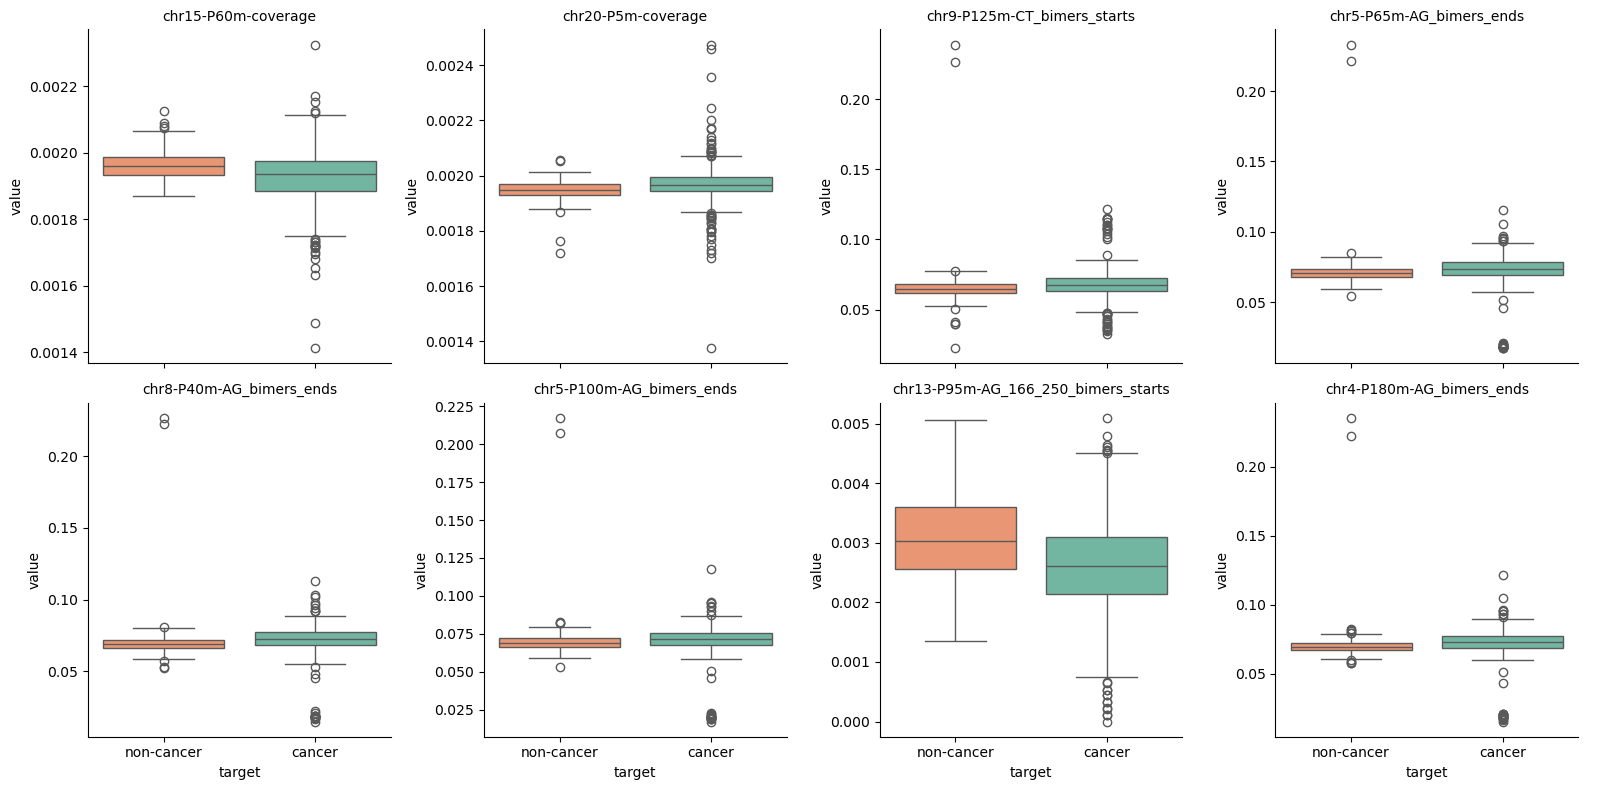

In [62]:
# Ensure correct feature selection
feature_index_list = dfiRanked_train.index.tolist() + ['target']

# Extract selected features from the DataFrame
top_features = df_5m[feature_index_list].copy()  # Avoid chained assignment warnings

# Create a temporary column and rename back to 'target'
top_features['target_temp'] = top_features['target'].map({0: 'non-cancer', 1: 'cancer'}).astype('category')

# Drop the original target column and rename the temp column
top_features.drop('target', axis=1, inplace=True)
top_features.rename(columns={'target_temp': 'target'}, inplace=True)

# Normalize feature columns by dividing by their means
top_features_normalized = top_features.iloc[:, :-1].div(top_features.iloc[:, :-1].mean(), axis=1)

# Add back the 'target' column
top_features_normalized['target'] = top_features['target']

# Display the first few rows
top_features_normalized.head()

def melt_feature_df(df):
    df_melted = df.reset_index().rename(columns={'index': 'sample'}).melt(
    id_vars=['sample', 'target'], var_name='feature', value_name='value')    
    return df_melted

top_features_norm_melted = melt_feature_df(top_features_normalized)
top_features_melted = melt_feature_df(top_features)

# Correct the FacetGrid mapping with adjusted boxplot settings
g = sns.FacetGrid(top_features_melted, col="feature", col_wrap=4, sharey=False, height=4)
# Use a custom function to map boxplots without passing unexpected arguments
def boxplot(data, **kwargs):
    sns.boxplot(x='target', y='value', data=data, hue='target', palette='Set2', order=['non-cancer', 'cancer'])
# Map the corrected boxplot function onto the grid
g.map_dataframe(boxplot)
# Remove 'feature=' from titles
g.set_titles('{col_name}')
# Add a legend
g.add_legend()
# Show the plot
plt.show()

### **Classifier Performance on Blind Test Set**

#### **Results Overview:**
The following classifiers achieved perfect performance in predicting blind test set samples.

In [68]:
df_acc = pd.read_csv('results/1-input_tpot_scjs_241128_smp_5m2_plus/final_classifiers/input_tpot_scjs_241128_smp_5m2_plus-final_classifiers_blind_test_results.csv')
df_acc.rename(columns={'Unnamed: 0': 'Classifier'}, inplace=True)

list_classifiers1 = ['RandomForestClassifier_228', 'XGBClassifier_459', 'BernoulliNB_475', 'ExtraTreesClassifier_55']
df_acc = (
    df_acc.loc[df_acc['Classifier'].isin(list_classifiers1)]
    .drop(columns=['Weighted_Score'])
    .style
    .hide(axis='index')
)

display(df_acc)

#display(df_acc.sort_values('Weighted_Score').head(2))

Classifier,Accuracy,Sensitivity,Specificity,Confusion_Matrix
RandomForestClassifier_228,1.000000,1.000000,1.000000,[[81 0] [ 0 81]]
XGBClassifier_459,1.000000,1.000000,1.000000,[[81 0] [ 0 81]]


#### **Important Note:**

- **Testing on a larger sample size is needed** to obtain more **realistic accuracy values**.

## **Internship Takeaways**

---

### **What I Learned During My Internship**

#### **Technical & Analytical Skills:**
- **Python Development:** Advanced proficiency in Python coding and pandas for data analysis.
  
- **Linux Environment:** Comfortable working in Linux-based systems for data processing.

- **NGS Pipeline Development:** Experience in next-generation sequencing (NGS) workflow design and implementation.

- **Fragmentomics & Feature Engineering:** Expertise in fragmentomics, feature extraction, and feature selection.

- **Machine Learning & Model Development:** Applied ML techniques using TPOT and scikit-learn for predictive modeling.

  ---


## **Internship Takeaways**

---

### **What I Learned During My Internship**

#### **Business & Professional Insights:**
- **Start-Up Environment:** Gained insights into start-up dynamics, project management, and business development in a biotech setting.

---

**Takeaway:**  
This internship has significantly enhanced both my **technical** and **professional** skills, preparing me for future challenges in **computational biology**, **bioinformatics**, and **machine learning**.
